In [1]:
import numpy as np, numpy.random as npr, torch.nn as nn, timeit, torch, pystan as ps, arviz
from time import time
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import plot, show, legend
from samplers import *

#### Generate data:

In [2]:
n_in = 1
n_out = 2

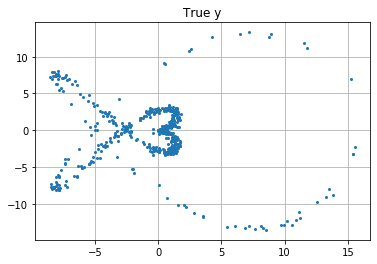

In [3]:
error_sigma2 = 0.05
dd = np.load("model1.npy")
X, Y = dd.item()['X'], dd.item()['Y']
X.requires_grad = True
plt.plot(list(Y[:,0]), list(Y[:,1]), 'o', markersize=2)
plt.grid(True)
plt.title("True y")
criterion = nn.MSELoss()
Nobs = np.shape(X)[0]

#### Compile Stan function:

In [4]:
sm = ps.StanModel(file="nn_basic.stan")

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_9e34de9b1de674bc98fb0d4b1bb21f0b NOW.


In [5]:
data = dict(Nobs=Nobs, 
           in_dim=n_in, 
           out_dim=n_out, 
           hidden_dim_1=50,
           y=Y.detach().numpy())

#### Run sampling algorithm:

In [6]:
control = dict(adapt_delta=0.9, max_treedepth=12)
start = time()
fit = sm.sampling(data=data, thin=1, n_jobs=1, init="random", iter=1_000, control=control, chains=1)
print(round((time()-start)/60,2), "minutes to run")
print(fit);

240.46 minutes to run
Inference for Stan model: anon_model_9e34de9b1de674bc98fb0d4b1bb21f0b.
1 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=500.

                  mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
X[1,1]             0.7    0.01   0.04   0.62   0.67    0.7   0.72   0.77      9   1.04
X[2,1]           12.99    0.25   1.11  10.95  12.24  12.92  13.73  15.44     19   1.07
X[3,1]           -5.79    0.06   0.65   -7.0  -6.28  -5.79  -5.31   -4.5    132    1.0
X[4,1]          -11.11    0.24   0.98  -12.7 -11.84 -11.17 -10.49  -8.89     17   1.03
X[5,1]          -21.89    0.25   0.95 -23.44 -22.62 -21.98 -21.36 -19.62     15   1.09
X[6,1]            5.38    0.17   0.34   4.76   5.11   5.38   5.64   6.01      4   1.74
X[7,1]            0.25  8.3e-3   0.04   0.16   0.22   0.25   0.28   0.33     29    1.0
X[8,1]          -13.67    0.22   0.51 -14.67 -14.01 -13.67 -13.32 -12.69      5   1.49
X[9,1]   

In [7]:
trace = fit.extract()
(fit.get_sampler_params())

[OrderedDict([('accept_stat__',
               array([1.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
                      9.95593926e-001, 9.95935182e-001, 9.99987651e-001, 1.00000000e+000,
                      9.98935032e-001, 9.98139806e-001, 9.39049581e-001, 9.91399036e-001,
                      5.75453982e-001, 9.98879821e-001, 9.93288129e-001, 9.10179895e-001,
                      8.27775934e-001, 9.79692902e-001, 9.88992105e-001, 4.93714963e-003,
                      9.99736536e-001, 9.96855196e-001, 9.93746734e-001, 9.98744783e-001,
                      9.82775578e-001, 9.79217222e-001, 9.39959282e-001, 6.23158858e-001,
                      1.00000000e+000, 7.11151527e-001, 9.90117170e-001, 3.72628710e-001,
                      9.70926522e-001, 9.99832901e-001, 9.91884415e-001, 9.98923665e-001,
                      8.65361461e-001, 6.77231903e-001, 9.43761678e-001, 8.86374588e-001,
                      3.88429667e-001, 9.85130053e-001, 9.38353669e-

### Plot IACTs:

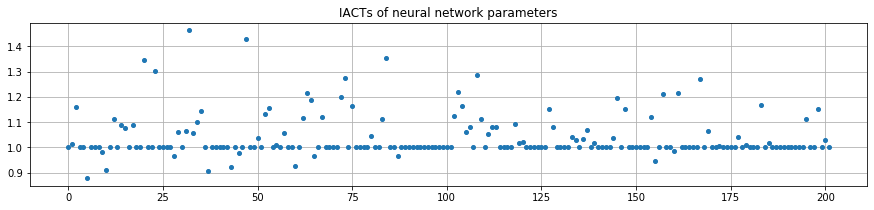

In [8]:
iact_nn = [gewer_estimate_IAT(trace['weights_1'][:,0,j]) 
          for j in range(np.shape(trace['weights_1'])[-1])] + \
         [gewer_estimate_IAT(trace['bias_1'][:,j]) 
         for j in range(np.shape(trace['bias_1'])[-1])] + \
[gewer_estimate_IAT(trace['weights_2'][:,i,j]) 
         for i in range(np.shape(trace['weights_2'])[-2]) 
         for j in range(np.shape(trace['weights_2'])[-1])] + \
[gewer_estimate_IAT(trace['bias_2'][:,j]) 
         for j in range(np.shape(trace['bias_2'])[-1])]
plt.figure(figsize=(15,3))
plt.plot(iact_nn, 'o', markersize=4)
plt.grid(True)
plt.title("IACTs of neural network parameters");

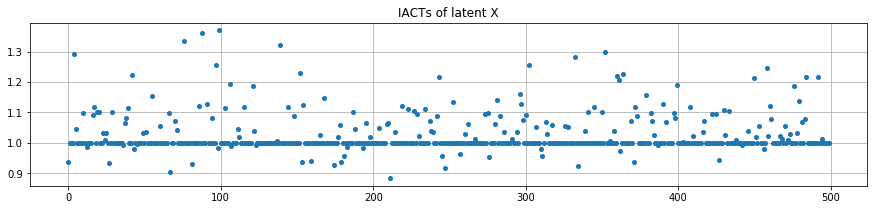

In [9]:
iact_x = [gewer_estimate_IAT(trace['X'][:,i,0]) for i in range(np.shape(trace['X'])[-2])]
plt.figure(figsize=(15,3))
plt.plot(iact_x, 'o', markersize=4)
plt.grid(True)
plt.title("IACTs of latent X");

#### Plot final:

In [25]:
n_HMC = np.shape(trace['X'])[0]
y_predicted = np.zeros((n_HMC, Nobs, n_out))
for i in range(Nobs) :
    y_predicted[i] = np.matmul(np.tanh(trace['X'][i]*trace['weights_1'][i] +
                                       trace['bias_1'][i]),trace['weights_2'][i]) + \
    trace['bias_2'][i] 

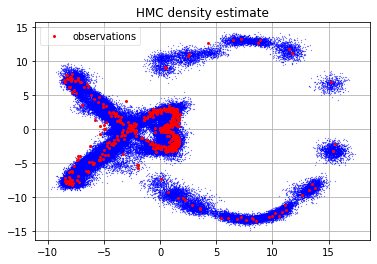

In [33]:
fig = plt.figure()
for i in range(Nobs) :
    plt.plot(y_predicted[i,:,0],y_predicted[i,:,1], 'bo', markersize=0.2)
plt.plot(list(Y[:,0]), list(Y[:,1]), 'ro', markersize=2, label="observations")
plt.grid(True)
plt.title("HMC density estimate");
plt.legend(ncol=2, loc='upper left', fancybox=True, framealpha=0.5)
fig.savefig('density_basic.png', dpi=1000, bbox_inches = 'tight')

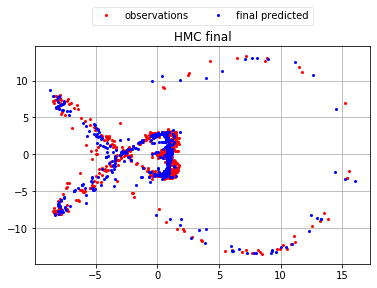

In [34]:
fig = plt.figure()
trace = fit.extract()
y_pred = np.matmul(np.tanh(trace['X'][-1]*trace['weights_1'][-1] \
                           + trace['bias_1'][-1]),trace['weights_2'][-1]) \
         + trace['bias_2'][-1] 

plt.plot(list(Y[:,0]), list(Y[:,1]), 'ro', markersize=2, label="observations")
plt.plot(y_pred[:,0],y_pred[:,1], 'bo', markersize=2, label="final predicted")
plt.grid(True)
plt.legend(ncol=2, loc=[0.17,1.1], fancybox=True, framealpha=0.5)
plt.title("HMC final");
fig.savefig('final_basic.png', dpi=1000, bbox_inches = 'tight')

### Predictive distribution:

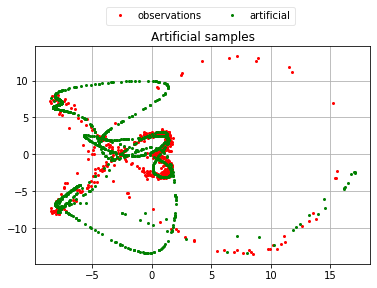

In [40]:
fig = plt.figure()
Ntest = 1_000
X_test = npr.randn(Ntest, n_in)
y_test = np.matmul(np.tanh(X_test*trace['weights_1'][-1] \
                           + trace['bias_1'][-1]),trace['weights_2'][-1]) \
         + trace['bias_2'][-1] 
plt.plot(list(Y[:,0]), list(Y[:,1]), 'ro', markersize=2, label="observations")
plt.plot(y_test[:,0],y_test[:,1], 'go', markersize=2, label="artificial")
plt.grid(True)
plt.title("Artificial samples");
plt.legend(ncol=2, loc=[0.21,1.1], fancybox=True, framealpha=0.5);
fig.savefig('predicted_basic.png', dpi=1000, bbox_inches = 'tight')